In [31]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange
from utils.network import *
from utils.create_data import *
from utils.data import *
from utils.metrics import plot_tsne
import random

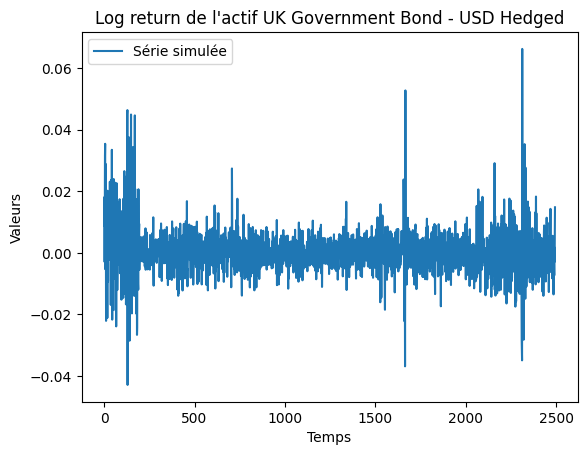

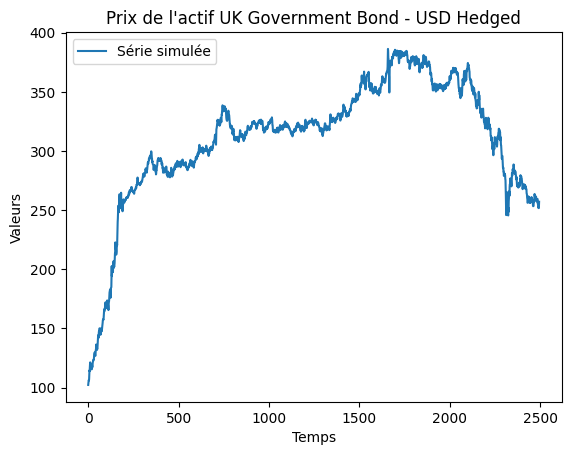

In [32]:
df = pd.read_csv('./data/GANData.csv')
actif = "UK Government Bond - USD Hedged"
sdf = df[df['ASSETNAME']==actif]['PRICE']
y = np.log(sdf/sdf.shift(1))[1:].to_numpy()
true_y = df[df['ASSETNAME']==actif]['PRICE'].to_numpy()
simple_plot(y[:], f"Log return de l'actif {actif}")
simple_plot(true_y[:], f"Prix de l'actif {actif}")

In [33]:
from utils.network import *

In [34]:
import torch
import torch.nn as nn

# On définit un générateur de GAN "basique"
class Generator(nn.Module):
    def __init__(self, latent_dim, ts_dim, condition):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, ts_dim-condition),
            #nn.Tanh() 
        )

    def forward(self, x):
        return self.model(x)

# Définir le discriminateur
class Discriminator(nn.Module):
    def __init__(self, ts_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(ts_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Pour obtenir une probabilité entre 0 et 1
        )

    def forward(self, x):
        return self.model(x)

In [36]:
latent_dim = 20 # Dimension du "bruit" d'entrée
ts_dim = 50 # Dimension de sortie
conditional = 10 # Dimension de la partie "commune"

generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)#, dropout_prob=0.2, hidden = 64)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 20
batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print("Utilisation du Gpu :",use_cuda)

print("Nombre de paramètres à entrainer : ", sum(p.numel() for p in generator.parameters() if p.requires_grad))

train = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda, _lambda=3)
train.train_model(epochs=epochs)

Utilisation du Gpu : False
Nombre de paramètres à entrainer :  45992


In [38]:
from utils.network import generate_fake_scenario

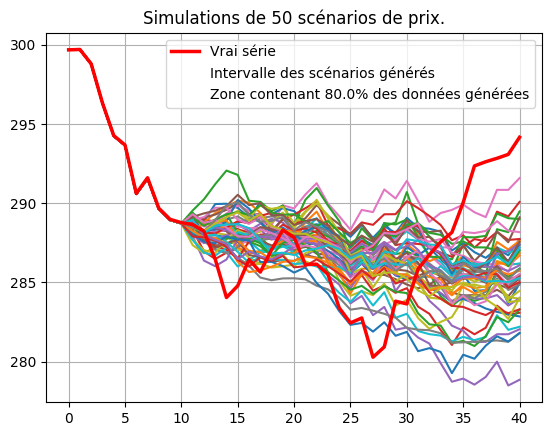

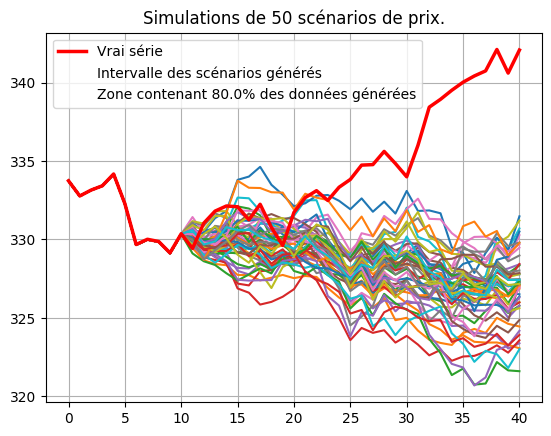

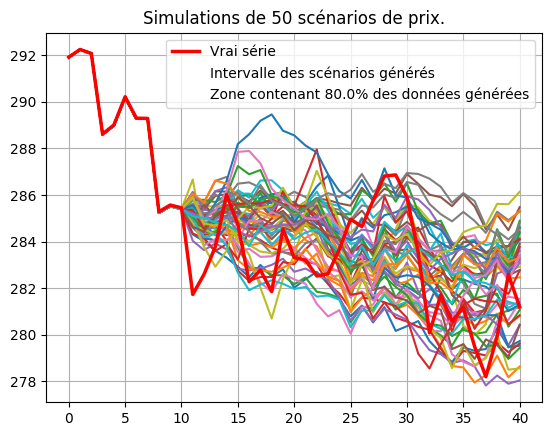

In [49]:
for i in range(3):
    start = random.randint(200,2000)
    generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 1,num =50, reducer=30,j=0.8, alphas=[1,0,0], count_error=False)

On voit que tout les scénarios générés ont la même allure, c'est le problème de mode collapse. En affichant seulement les log return générés, on voit bien que les scénarios générés manquent beaucoup de diversité.

433


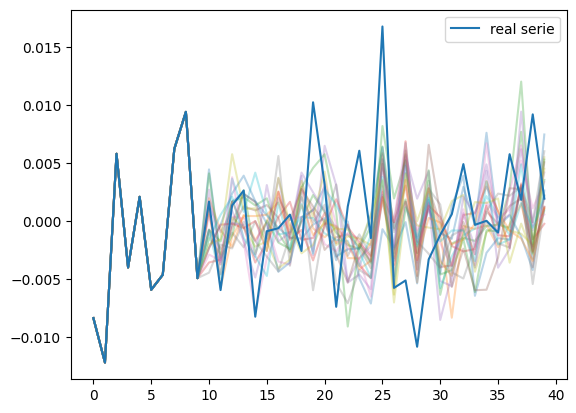

In [56]:
def show_generations(num, train, amplifier=1, reducer=4, show_real=True):
    start = random.randint(200,2000)
    amplifier = 1
    noise = torch.randn((num, 1, train.latent_dim)) * amplifier
    real_samples = torch.from_numpy(y[start:start+train.conditional])
    noise[:, :, :train.conditional] = real_samples
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    noise = noise.to(device)
    v = train.G(noise) / reducer
    v[:, :, :train.conditional] = real_samples
    v = np.array(v.float().cpu().detach()[:, 0,  :])
    print(start)
    for ar in v:
        plt.plot(ar, alpha=0.3)
    if show_real:
        plt.plot(y[start:start+train.ts_dim-train.conditional], label='real serie')
    plt.legend()
show_generations(20,train, reducer=20)

Une première méthode simple pour éviter l'overfitting est de rajouter un paramètre de dropout

In [57]:
import torch
import torch.nn as nn

# On rajoute le dropout pour éviter l'overfitting
class Generator(nn.Module):
    def __init__(self, latent_dim, ts_dim, condition, dropout_rate=0.5):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Ajout de la couche Dropout
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Ajout de la couche Dropout
            nn.Linear(256, ts_dim - condition),
            #nn.Tanh()  
        )

    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self, ts_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(ts_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  
        )

    def forward(self, x):
        return self.model(x)


In [61]:
latent_dim = 20 # Dimension du "bruit" d'entrée
ts_dim = 50 # Dimension de sortie
conditional = 10 # Dimension de la partie "commune"

generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)#, dropout_prob=0.2, hidden = 64)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 20
batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print("Utilisation du Gpu :",use_cuda)

print("Nombre de paramètres à entrainer : ", sum(p.numel() for p in generator.parameters() if p.requires_grad))

train = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda, _lambda=3)
train.train_model(epochs=epochs)

Utilisation du Gpu : False
Nombre de paramètres à entrainer :  45992


  0%|          | 0/20 [00:00<?, ?it/s]/home/onyxia/work/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1346: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


1817


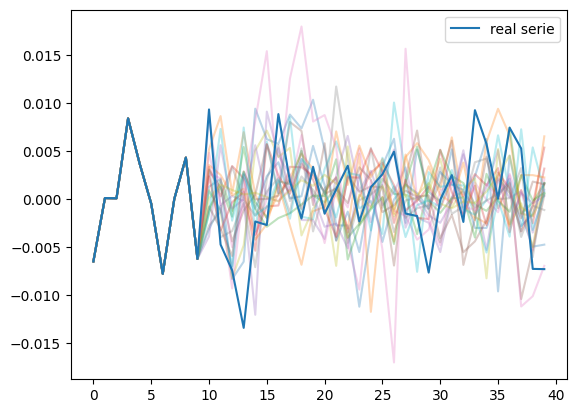

In [68]:
show_generations(20,train, reducer=40)

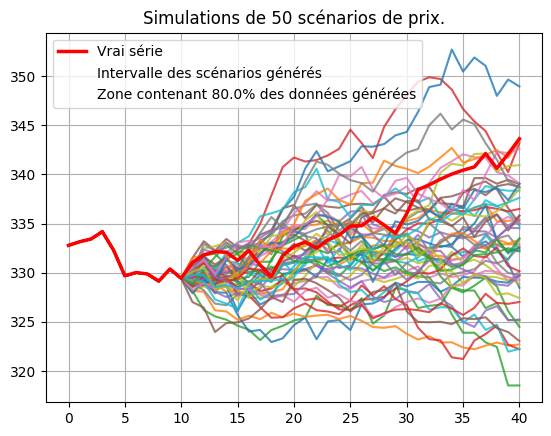

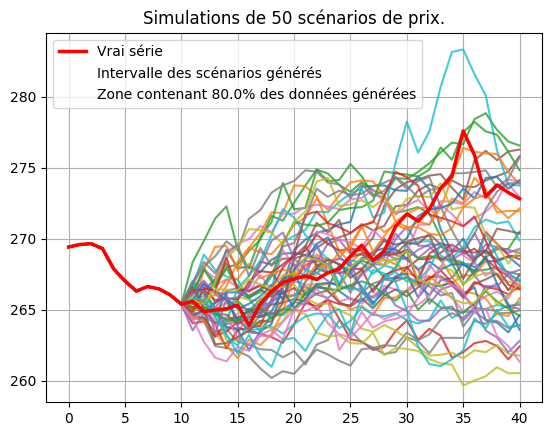

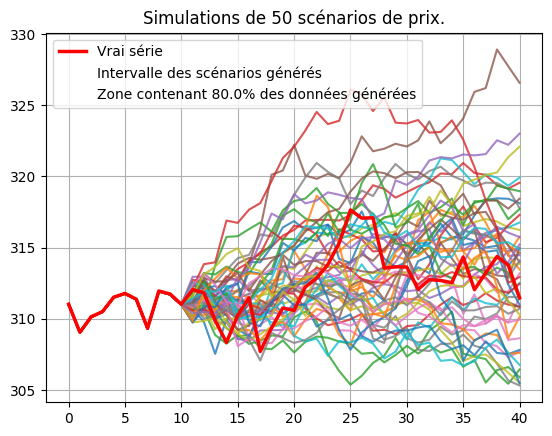

In [69]:
for i in range(3):
    start = random.randint(200,2000)
    generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 1,num =50, reducer=40,j=0.8, alphas=[0.8,0,0], count_error=False)

Le résultat est déjà plus satisfaisant

In [ ]:
from utils.metrics import evaluate_fake_scenario

Nombre d'erreur moyenne pour 101 scénarios : 0.005/40: 100%|██████████| 100/100 [08:32<00:00,  5.12s/it]


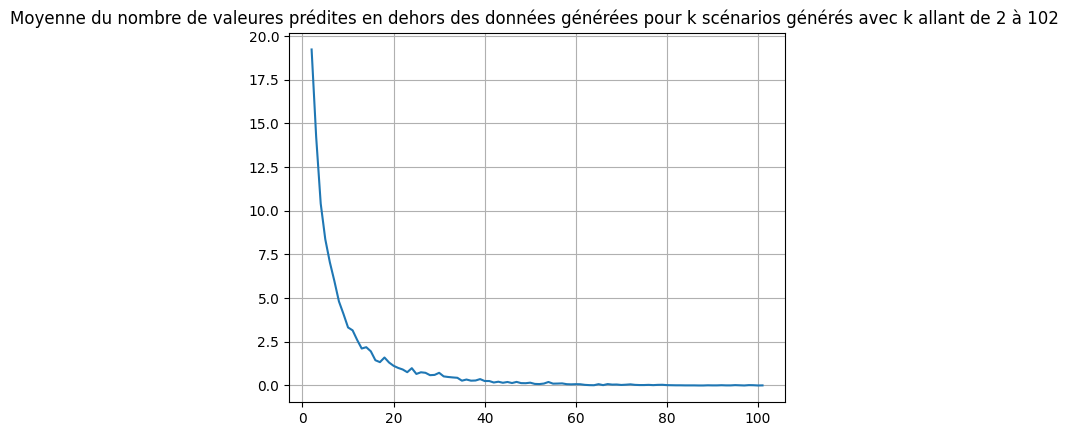

In [70]:
list_val=[]
pb = trange(100)
for k in pb:
    score = evaluate_fake_scenario(y[200:],true_y[200:],train, amplifier = 1,num = k+2,reducer=40, n=200, no_print=True)
    pb.set_description(f"Nombre d'erreur moyenne pour {k+2} scénarios : {score}/{train.ts_dim-10}")
    list_val.append(score)
indices = range(2, len(list_val) + 2)

plt.plot(indices, list_val)
plt.title(f"Moyenne du nombre de valeures prédites en dehors des données générées pour k scénarios générés avec k allant de 2 à {len(list_val) + 2} ")
plt.grid(True)
plt.show()

In [71]:
from utils.metrics import plot_tsne

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.013355
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.518593
[t-SNE] KL divergence after 300 iterations: 0.992407


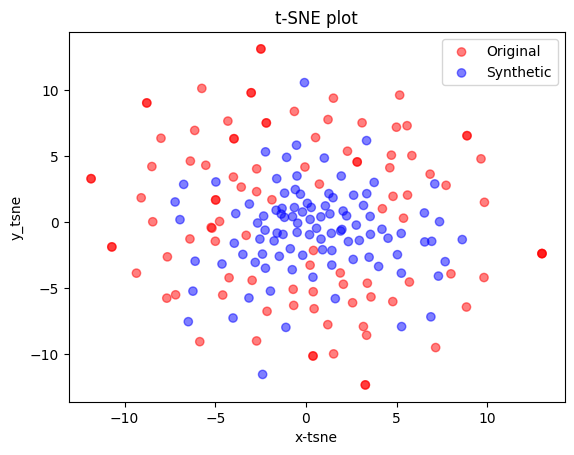

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 220 samples in 0.000s...
[t-SNE] Computed neighbors for 220 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 220 / 220
[t-SNE] Mean sigma: 0.014007
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.513947
[t-SNE] KL divergence after 300 iterations: 0.975679


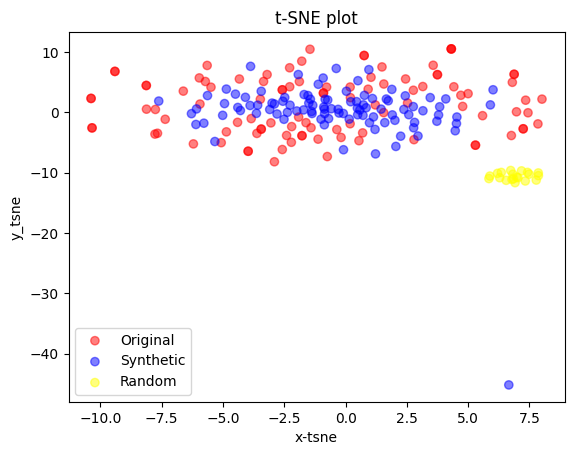

In [78]:
fake , real = train.data.get_samples(G = train.G, latent_dim = train.latent_dim, ts_dim = train.ts_dim, 
                    batch_size=100, conditional= train.conditional, use_cuda=train.use_cuda, data = train.data)
fake = fake/30
real_array = real.float().cpu().detach().numpy()
fake_array = fake.float().cpu().detach().numpy()
plot_tsne(real_array,fake_array, random=False)
plot_tsne(real_array,fake_array, random=True)

In [85]:
from utils.metrics import get_moments
mom = get_moments(train, reducer=40)
mom

100%|██████████| 1000/1000 [00:12<00:00, 80.14it/s]


{'real mean': 0.008995264,
 'fake mean': 0.00032330048,
 'real var': 0.014216352,
 'fake var': 4.8665366e-05,
 'real skew': 0.13246727,
 'fake skew': 0.4451218,
 'real kurtosis': 1.0953829,
 'fake kurtosis': 3.8315327}

In [88]:
from utils.network_lstm import LSTMGenerator, LSTMDiscriminator

In [100]:
latent_dim = 20 # Dimension du "bruit" d'entrée
ts_dim = 50 # Dimension de sortie
conditional = 10 # Dimension de la partie "commune"

generator = LSTMGenerator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional, dropout=0.5, hidden_dim=128)#, dropout_prob=0.2, hidden = 64)
discriminator = LSTMDiscriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 50
batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print("Utilisation du Gpu :",use_cuda)

print("Nombre de paramètres à entrainer : ", sum(p.numel() for p in generator.parameters() if p.requires_grad))

train_lstm = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda, _lambda=3)
train_lstm.train_model(epochs=epochs)

Utilisation du Gpu : False
Nombre de paramètres à entrainer :  81960


  0%|          | 0/50 [00:00<?, ?it/s]/home/onyxia/work/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1346: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
                                                                                              

Arret préliminaire, aucune amélioration du modèle depuis 10 epochs


606


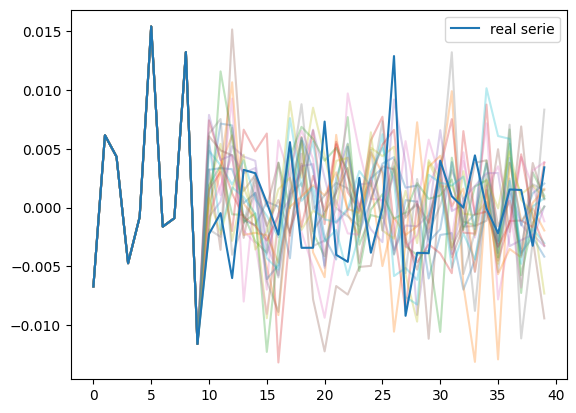

In [111]:
show_generations(train =train_lstm, num=20, reducer = 10)

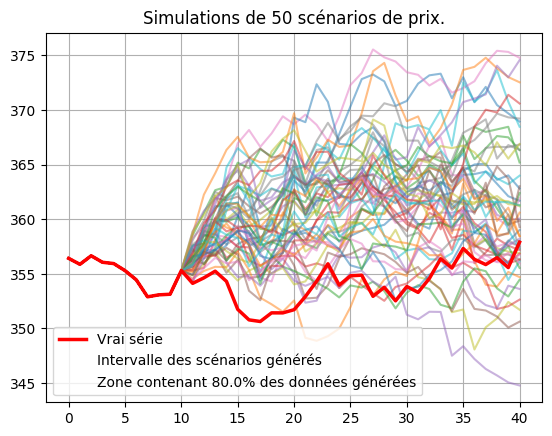

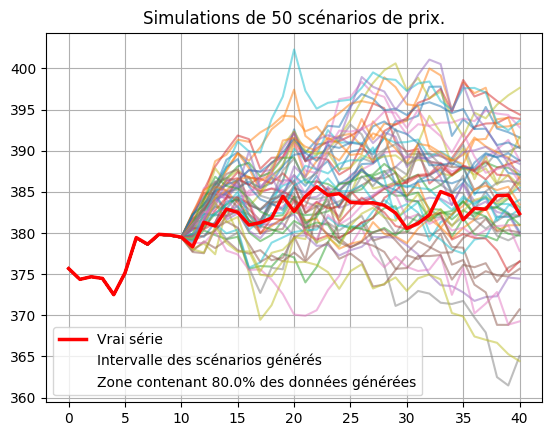

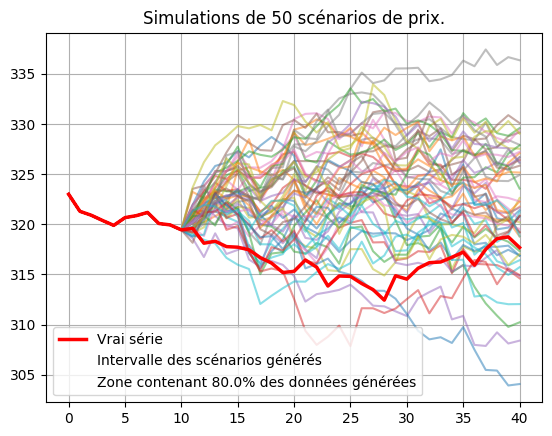

In [115]:
for i in range(3):
    start = random.randint(200,2000)
    generate_fake_scenario(y[start:],true_y[start:],train_lstm, amplifier = 1,num =50, reducer=10,j=0.8, alphas=[0.5,0,0], count_error=False)

In [102]:
get_moments(train_lstm)

100%|██████████| 1000/1000 [00:10<00:00, 91.96it/s]


{'real mean': 0.0003146256,
 'fake mean': 0.00032592934,
 'real var': 0.0015795347,
 'fake var': 4.9250968e-05,
 'real skew': 0.09926315,
 'fake skew': 0.45122388,
 'real kurtosis': 0.87021047,
 'fake kurtosis': 3.8878996}

In [116]:
from utils.network import Generator, Discriminator

In [118]:
latent_dim = 20 # Dimension du "bruit" d'entrée
ts_dim = 50 # Dimension de sortie
conditional = 10 # Dimension de la partie "commune"

generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)#, dropout=0.5, hidden_dim=128)#, dropout_prob=0.2, hidden = 64)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 50
batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print("Utilisation du Gpu :",use_cuda)

print("Nombre de paramètres à entrainer : ", sum(p.numel() for p in generator.parameters() if p.requires_grad))

train_cnn = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda, _lambda=3)
train_cnn.train_model(epochs=epochs)

Utilisation du Gpu : False
Nombre de paramètres à entrainer :  262962


  0%|          | 0/50 [00:00<?, ?it/s]

/home/onyxia/work/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1346: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


1120


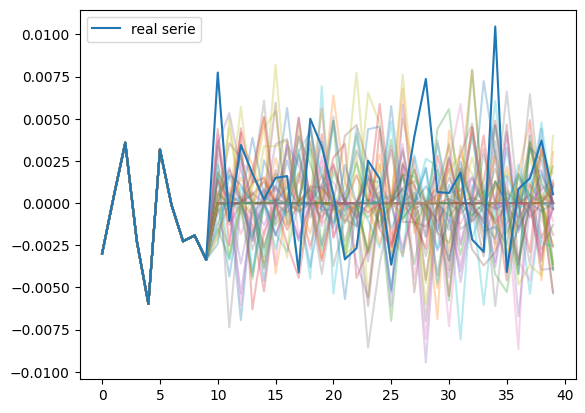

In [121]:
show_generations(train = train_cnn,num=50, reducer=10)

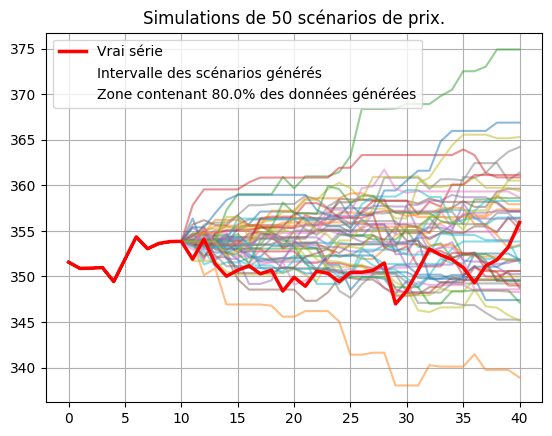

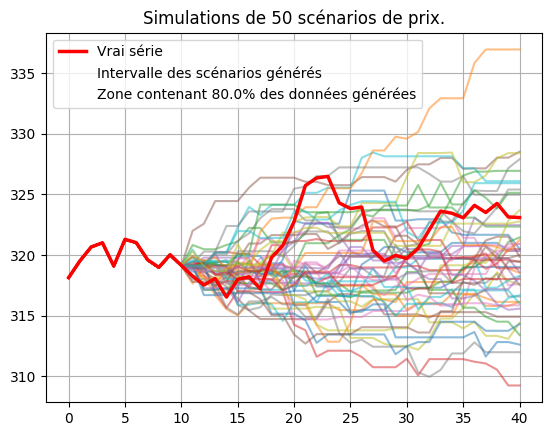

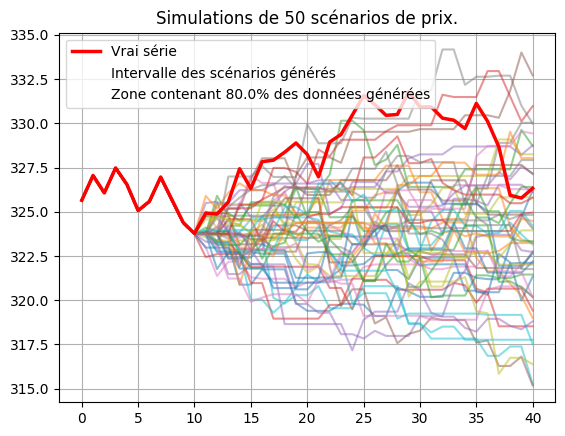

In [179]:
for i in range(3):
    start = random.randint(200,2000)
    generate_fake_scenario(y[start:],true_y[start:],train_cnn, amplifier = 1,num =50, reducer=8,j=0.8, alphas=[0.5,0,0], count_error=False)

In [124]:
get_moments(train_cnn)

100%|██████████| 1000/1000 [01:24<00:00, 11.83it/s]


{'real mean': 0.00022608215,
 'fake mean': 0.00032491522,
 'real var': 0.00035188094,
 'fake var': 4.9287886e-05,
 'real skew': 0.13910362,
 'fake skew': 0.45257482,
 'real kurtosis': 2.7835896,
 'fake kurtosis': 3.8951628}

In [149]:
Moments_base = get_moments(train)
Moments_lstm = get_moments(train_lstm)
Moments_cnn = get_moments(train_cnn)

100%|██████████| 1000/1000 [02:17<00:00,  7.27it/s]


In [171]:
diff_moments_base = {}
for key in Moments_base.keys():
    if key.startswith('real'):
        diff_moments_base[f'diff {key[5:]}'] = abs(Moments_base[key]-Moments_base[f'fake {key[5:]}'])
diff_moments_lstm = {}
for key in Moments_lstm.keys():
    if key.startswith('real'):
        diff_moments_lstm[f'diff {key[5:]}'] = abs(Moments_lstm[key]-Moments_lstm[f'fake {key[5:]}'])
diff_moments_cnn = {}
for key in Moments_cnn.keys():
    if key.startswith('real'):
        diff_moments_cnn[f'diff {key[5:]}'] = abs(Moments_cnn[key]-Moments_cnn[f'fake {key[5:]}'])


In [176]:
df = pd.DataFrame([diff_moments_base, diff_moments_lstm, diff_moments_cnn], index=['Base GAN', 'LSTM GAN', 'DC-GAN'])
def highlight_min(s):
    is_min = s == s.min()
    return ['color: red' if v else '' for v in is_min]
df = df.style.apply(highlight_min)
df

,diff mean,diff var,diff skew,diff kurtosis
Base GAN,0.008611,0.014143,0.316577,2.770563
LSTM GAN,0.000033,0.001536,0.345370,2.987339
DC-GAN,0.000078,0.000302,0.307701,1.117386


In [180]:

%pip install table_evaluator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 80.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 57.8 MB/s eta 0:00:00
anceled
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from table_evaluator import TableEvaluator

TableEvaluator